In [ ]:
###########################################
############## PLEASE NOTE ################
###########################################
# The paths in this notebook will not work
# locally. This notebook requires access
# to the tmax/tmin files of each CMIP 
# and NEX-GDDP model. 
###########################################
###########################################

In [1]:
from pathlib import Path
fpath = Path("./Avenir.ttc")

import matplotlib.font_manager as fm

fe = fm.FontEntry(
    fname=fpath,
    name='avenir')
fm.fontManager.ttflist.insert(0, fe) # or append is fine
import matplotlib as mpl
mpl.rcParams['font.family'] = fe.name # = 'your custom ttf font name'

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import cftime
import regionmask
import dask
dask.config.set({"array.slicing.split_large_chunks": False});

import warnings
warnings.simplefilter("ignore", RuntimeWarning) # Ignore invalid arcsin() in EDD calculation

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature

In [17]:
# For plotting
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lakes',
    scale='50m',
    facecolor='none')

plt.rcParams['font.size'] = 18
plt.rcParams['pdf.fonttype'] = 42

cm_data = np.loadtxt("./tools/vik.txt")
vik_map = LinearSegmentedColormap.from_list('vik', cm_data)

cm_data = np.loadtxt("./tools/nuuk.txt")
nuuk_map = LinearSegmentedColormap.from_list('nuuk', cm_data)

In [4]:
def get_norm(lst):

    minima = min(lst)
    maxima = max(lst)

    return mpl.colors.Normalize(vmin=minima, vmax=maxima, clip=True)

def get_custom_cmap(lst, cmap):

    minima = min(lst)
    maxima = max(lst)

    norm = get_norm(lst)
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap)
    
    return [mapper.to_rgba(v) for v in lst]

In [5]:
# degree day function
def above_threshold_each(mins, maxs, threshold):
    """Use a sinusoidal approximation to estimate the number of Growing
    Degree-Days above a given threshold, using daily minimum and maximum
    temperatures.
    mins and maxs are numpy arrays; threshold is in the same units."""
    
    """
    Code from James Rising (https://github.com/jrising/research-common/blob/master/python/gdd.py)
    """

    # Determine crossing points, as a fraction of the day
    plus_over_2 = (mins + maxs)/2
    minus_over_2 = (maxs - mins)/2
    two_pi = 2*np.pi
    # d0s is the times of crossing above; d1s is when cross below
    d0s = np.arcsin((threshold - plus_over_2) / minus_over_2) / two_pi
    d1s = .5 - d0s

    # If always above or below threshold, set crossings accordingly
    aboves = mins >= threshold
    belows = maxs <= threshold

    d0s[aboves] = 0
    d1s[aboves] = 1
    d0s[belows] = 0
    d1s[belows] = 0

    # Calculate integral
    F1s = -minus_over_2 * np.cos(2*np.pi*d1s) / two_pi + plus_over_2 * d1s
    F0s = -minus_over_2 * np.cos(2*np.pi*d0s) / two_pi + plus_over_2 * d0s
    return F1s - F0s - threshold * (d1s - d0s)

In [60]:
# Dask
from dask_jobqueue import PBSCluster
cluster = PBSCluster(resource_spec = 'pmem=10gb', env_extra= ['#PBS -l feature=rhel7'])

cluster.scale(jobs=5)  # ask for jobs

from dask.distributed import Client
client = Client(cluster)

# Native grid-cell figures (US & global)

## NEX EDD

In [6]:
# Get list of models
models = !ls /gpfs/group/kaf26/default/dcl5300/maize_yield_predictor_vars/egdd/NEX/data/GDD_29C_gs__historical_r1i1p1_*
models = [model.replace('/gpfs/group/kaf26/default/dcl5300/maize_yield_predictor_vars/egdd/NEX/data/GDD_29C_gs__historical_r1i1p1_','') for model in models]
models = [model.replace('.nc','') for model in models]

nex_path = '/gpfs/group/kaf26/default/dcl5300/maize_yield_predictor_vars/egdd/NEX/data/GDD_29C_gs__historical_r1i1p1_'

In [7]:
# Read in all
ds = []
for model in models:
    tmp = xr.open_dataset(nex_path + model + '.nc')
    tmp = tmp.rename({'GDD' : model})
    ds.append(tmp)
    
ds = xr.merge(ds)

In [8]:
# US subset
ds_US = ds.where((ds.lon <= 360-65) & (ds.lon >= 360-125) & (ds.lat <= 50) & (ds.lat >= 25), drop=True)

In [9]:
# US subset
countries_110 = regionmask.defined_regions.natural_earth.countries_110
mask_3D = countries_110.mask_3D(ds_US)
us_mask = mask_3D.sel(region=4)
ds_US = ds.where(us_mask, drop=True)

In [10]:
# EDD models
mpm_mean = 'CSIRO-Mk3-6-0'
mpm_q90 = 'GFDL-CM3'
mpm_sd = 'CESM1-BGC'
mpm_max = 'IPSL-CM5A-MR'

In [11]:
# Calculate summary stats
ds_US_mean = ds_US[mpm_mean].mean(dim=['time'])
ds_US_sd = ds_US[mpm_sd].std(dim=['time'])
ds_US_q90 = ds_US[mpm_q90].quantile(q=0.9, dim=['time'])
ds_US_max = ds_US[mpm_max].max(dim=['time'])

ds_mean = ds[mpm_mean].mean(dim=['time'])
ds_sd = ds[mpm_sd].std(dim=['time'])
ds_q90 = ds[mpm_q90].quantile(q=0.9, dim=['time'])
ds_max = ds[mpm_max].max(dim=['time'])

In [21]:
# Read in obs
obs = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/maize_yield_predictor_vars/egdd/GMFD/data/GDD_29C_gs_GMFD.nc')

In [22]:
# Initial subset
obs_US = obs.where((obs.lon <= 360-65) & (obs.lon >= 360-125) & (obs.lat <= 50) & (obs.lat >= 25), drop=True)

In [ ]:
# US subset
countries_110 = regionmask.defined_regions.natural_earth.countries_110
mask_3D = countries_110.mask_3D(ds)
us_mask = mask_3D.sel(region=4)
obs_US = obs.where(us_mask, drop=True)

In [ ]:
# Calculate summary stats
obs_mean = obs.mean(dim=['time'])
obs_sd = obs.std(dim=['time'])
obs_q90 = obs.quantile(q=0.9, dim=['time'])
obs_max = obs.max(dim=['time'])

obs_US_mean = obs_US.mean(dim=['time'])
obs_US_sd = obs_US.std(dim=['time'])
obs_US_q90 = obs_US.quantile(q=0.9, dim=['time'])
obs_US_max = obs_US.max(dim=['time'])

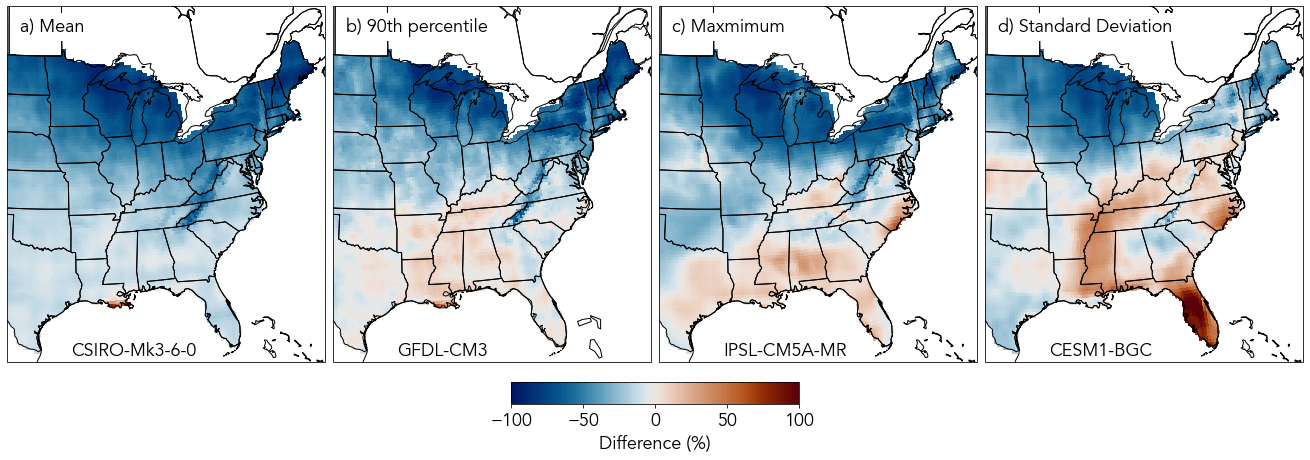

In [16]:
# US
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(1, 4, wspace = 0.025)

gs.update(top = 0.95, bottom = 0.1, left = 0.05, right = 0.95)
cax = fig.add_axes([0.4, 0.22, 0.2, 0.03])

vmin = -100.
vmax = 100.
cmap = vik_map

# Mean
ax = fig.add_subplot(gs[0], projection=ccrs.LambertConformal())
ax.set_extent([-100, -73, 25, 51], crs=ccrs.PlateCarree())

plotdata = (ds_US_mean - obs_US_mean) / np.abs(obs_US_mean) * 100
plotdata['GDD'].plot(ax=ax, transform = ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(states_provinces, edgecolor='black')
ax.coastlines(resolution='50m', color='black')
ax.text(0.04, 0.93, 'a) Mean', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath)
ax.text(0.2, 0.02, mpm_mean, transform=ax.transAxes, size=18, font=fpath)

# 90th percentile
ax = fig.add_subplot(gs[1], projection=ccrs.LambertConformal())
ax.set_extent([-100, -73, 25, 51], crs=ccrs.PlateCarree())

plotdata = (ds_US_q90 - obs_US_q90) / np.abs(obs_US_q90) * 100
plotdata['GDD'].plot(ax=ax, transform = ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(states_provinces, edgecolor='black')
ax.coastlines(resolution='110m', color='black')
ax.text(0.04, 0.93, 'b) 90th percentile', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath)
ax.text(0.2, 0.02, mpm_q90, transform=ax.transAxes, size=18, font=fpath)

# Max
ax = fig.add_subplot(gs[2], projection=ccrs.LambertConformal())
ax.set_extent([-100, -73, 25, 51], crs=ccrs.PlateCarree())

plotdata = (ds_US_max - obs_US_max) / np.abs(obs_US_max) * 100
plotdata['GDD'].plot(ax=ax, transform = ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(states_provinces, edgecolor='black')
ax.coastlines(resolution='50m', color='black')
ax.text(0.04, 0.93, 'c) Maxmimum', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath)
ax.text(0.2, 0.02, mpm_max, transform=ax.transAxes, size=18, font=fpath)

# SD
ax = fig.add_subplot(gs[3], projection=ccrs.LambertConformal())
ax.set_extent([-100, -73, 25, 51], crs=ccrs.PlateCarree())

plotdata = (ds_US_sd - obs_US_sd) / np.abs(obs_US_sd) * 100
plotdata['GDD'].plot(ax=ax, transform = ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(states_provinces, edgecolor='black')
ax.coastlines(resolution='50m', color='black')
ax.text(0.04, 0.93, 'd) Standard Deviation', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath)
ax.text(0.2, 0.02, mpm_sd, transform=ax.transAxes, size=18, font=fpath)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cb = fig.colorbar(sm, orientation = 'horizontal', shrink=0.4, cax = cax)
cb.set_label(label = 'Difference (%)', font=fpath)
for tick in cb.ax.get_xticklabels():
    tick.set_font(fpath)

plt.savefig('./figs/SIfig_NEX_EDD_grid_US_map.png', dpi=600)
# plt.show()

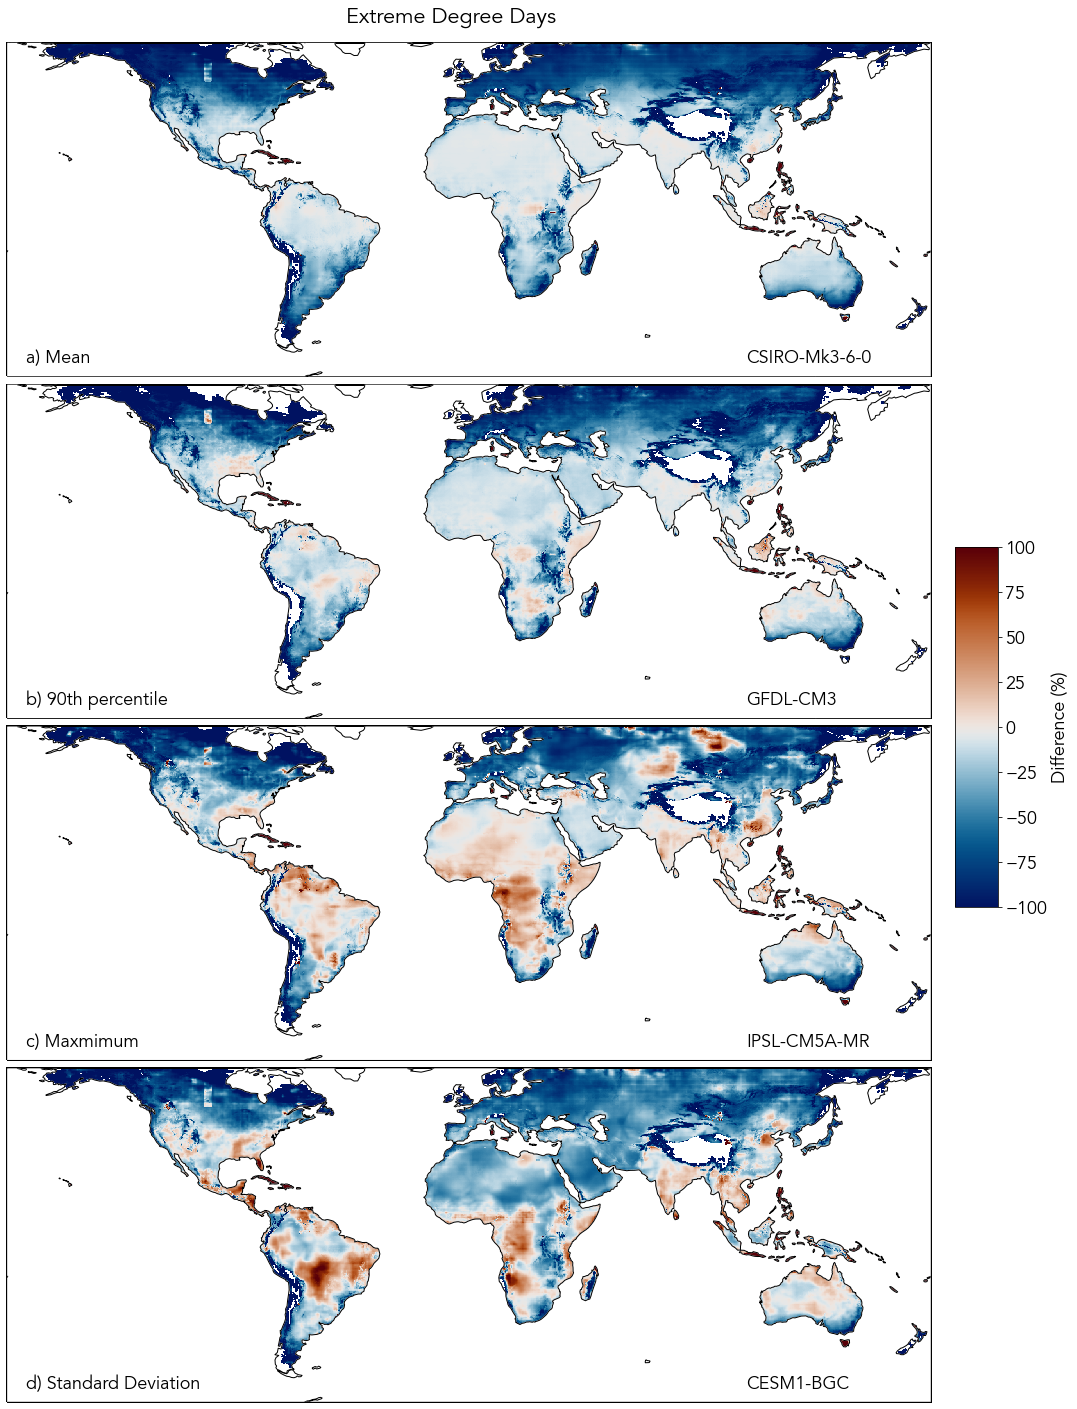

In [17]:
# Global
fig = plt.figure(figsize=(20,25))
gs = fig.add_gridspec(4,1, hspace=0.025)

cax = fig.add_axes([0.85, 0.4, 0.03, 0.2])

vmin = -100.
vmax = 100.
cmap = vik_map

# Mean
ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -65, 65], crs=ccrs.PlateCarree())

plotdata = (ds_mean - obs_mean) / np.abs(obs_mean) * 100
plotdata['GDD'].plot(ax=ax, transform=ccrs.PlateCarree(),  cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(cfeature.OCEAN, color='white', zorder=50)
ax.coastlines(resolution='110m', color='black', zorder=100)
ax.text(0.02, 0.04, 'a) Mean', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath, zorder=150)
ax.text(0.8, 0.04, mpm_mean, transform=ax.transAxes, size=18, font=fpath, zorder=150)
ax.spines['geo'].set_linewidth(2)
ax.spines['geo'].set_edgecolor('black')

# 90th percentile
ax = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -65, 65], crs=ccrs.PlateCarree())

plotdata = (ds_q90 - obs_q90) / np.abs(obs_q90) * 100
plotdata['GDD'].plot(ax=ax, transform = ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(cfeature.OCEAN, color='white', zorder=50)
ax.coastlines(resolution='110m', color='black', zorder=100)
ax.text(0.02, 0.04, 'b) 90th percentile', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath, zorder=150)
ax.text(0.8, 0.04, mpm_q90, transform=ax.transAxes, size=18, font=fpath, zorder=150)
ax.spines['geo'].set_linewidth(2)
ax.spines['geo'].set_edgecolor('black')

# Max
ax = fig.add_subplot(gs[2], projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -65, 65], crs=ccrs.PlateCarree())

plotdata = (ds_max - obs_max) / np.abs(obs_max) * 100
plotdata['GDD'].plot(ax=ax, transform = ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(cfeature.OCEAN, color='white', zorder=50)
ax.coastlines(resolution='110m', color='black', zorder=100)
ax.text(0.02, 0.04, 'c) Maxmimum', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath, zorder=150)
ax.text(0.8, 0.04, mpm_max, transform=ax.transAxes, size=18, font=fpath, zorder=150)
ax.spines['geo'].set_linewidth(2)
ax.spines['geo'].set_edgecolor('black')

# SD
ax = fig.add_subplot(gs[3], projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -65, 65], crs=ccrs.PlateCarree())

plotdata = (ds_sd - obs_sd) / np.abs(obs_sd) * 100
plotdata['GDD'].plot(ax=ax, transform = ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(cfeature.OCEAN, color='white', zorder=50)
ax.coastlines(resolution='110m', color='black', zorder=100)
ax.text(0.02, 0.04, 'd) Standard Deviation', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath, zorder=150)
ax.text(0.8, 0.04, mpm_sd, transform=ax.transAxes, size=18, font=fpath, zorder=150)
ax.spines['geo'].set_linewidth(2)
ax.spines['geo'].set_edgecolor('black')

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cb = fig.colorbar(sm, orientation = 'vertical', shrink=0.4, cax = cax)
cb.set_label(label = 'Difference (%)', font=fpath)
for tick in cb.ax.get_xticklabels():
    tick.set_font(fpath)
    
# Font
fig.suptitle('Extreme Degree Days', font_properties={'fname':fpath}, y=0.9)

plt.savefig('./figs/SIfig_NEX_EDD_grid_global_map.png', dpi=600)
# plt.show()

## NEX GDD

In [27]:
# Get list of models
models = !ls /gpfs/group/kaf26/default/dcl5300/maize_yield_predictor_vars/gdd/NEX/data/GDD_10*_historical_*
models = [model.replace('/gpfs/group/kaf26/default/dcl5300/maize_yield_predictor_vars/gdd/NEX/data/GDD_10-29C_gs__historical_r1i1p1_','') for model in models]
models = [model.replace('.nc','') for model in models]

nex_path = '/gpfs/group/kaf26/default/dcl5300/maize_yield_predictor_vars/gdd/NEX/data/GDD_10-29C_gs__historical_r1i1p1_'

In [28]:
# Read in all
ds = []
for model in models:
    tmp = xr.open_dataset(nex_path + model + '.nc')
    tmp = tmp.rename({'GDD' : model})
    ds.append(tmp)
    
ds = xr.merge(ds)

In [29]:
# US subset
ds_US = ds.where((ds.lon <= 360-65) & (ds.lon >= 360-125) & (ds.lat <= 50) & (ds.lat >= 25), drop=True)

In [30]:
# US subset
countries_110 = regionmask.defined_regions.natural_earth.countries_110
mask_3D = countries_110.mask_3D(ds_US)
us_mask = mask_3D.sel(region=4)
ds_US = ds.where(us_mask, drop=True)

In [31]:
# GDD models
mpm_mean = 'IPSL-CM5A-LR'
mpm_q10 = 'CanESM2'
mpm_sd = 'CNRM-CM5'
mpm_min = 'bcc-csm1-1'

In [32]:
# Calculate summary stats
ds_US_mean = ds_US[mpm_mean].mean(dim=['time'])
ds_US_sd = ds_US[mpm_sd].std(dim=['time'])
ds_US_q10 = ds_US[mpm_q10].quantile(q=0.1, dim=['time'])
ds_US_min = ds_US[mpm_min].min(dim=['time'])

ds_mean = ds[mpm_mean].mean(dim=['time'])
ds_sd = ds[mpm_sd].std(dim=['time'])
ds_q10 = ds[mpm_q10].quantile(q=0.1, dim=['time'])
ds_min = ds[mpm_min].min(dim=['time'])

In [33]:
# Read in obs
obs = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/maize_yield_predictor_vars/gdd/GMFD/data/GDD_10-29C_gs_GMFD.nc')

In [34]:
# Initial subset
obs_US = obs.where((obs.lon <= 360-65) & (obs.lon >= 360-125) & (obs.lat <= 50) & (obs.lat >= 25), drop=True)

In [35]:
# US subset
countries_110 = regionmask.defined_regions.natural_earth.countries_110
mask_3D = countries_110.mask_3D(ds)
us_mask = mask_3D.sel(region=4)
obs_US = obs.where(us_mask, drop=True)

In [36]:
# Calculate summary stats
obs_mean = obs.mean(dim=['time'])
obs_sd = obs.std(dim=['time'])
obs_q10 = obs.quantile(q=0.1, dim=['time'])
obs_min = obs.min(dim=['time'])

obs_US_mean = obs_US.mean(dim=['time'])
obs_US_sd = obs_US.std(dim=['time'])
obs_US_q10 = obs_US.quantile(q=0.1, dim=['time'])
obs_US_min = obs_US.min(dim=['time'])

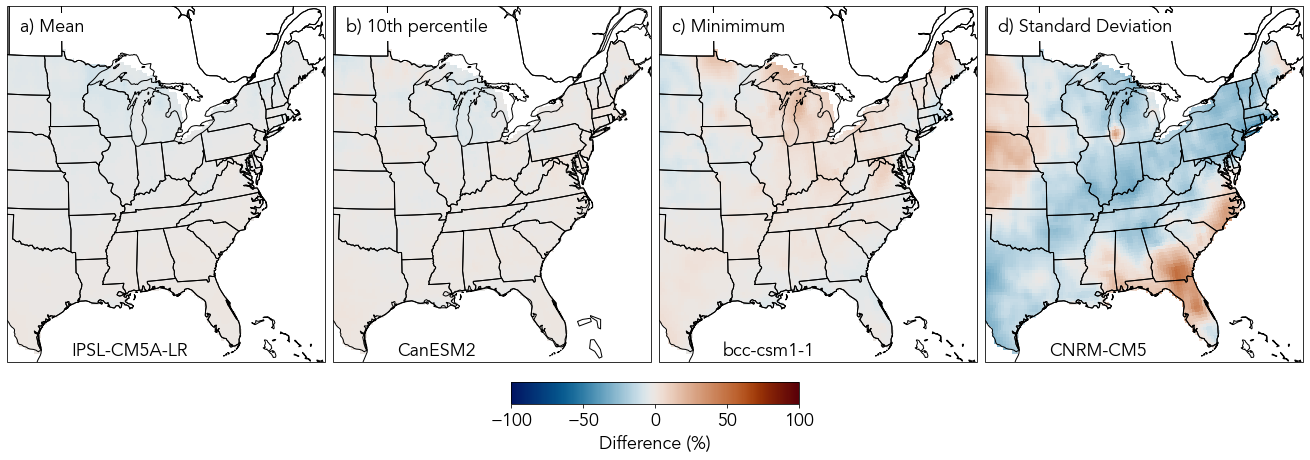

In [39]:
# US
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(1, 4, wspace = 0.025)

gs.update(top = 0.95, bottom = 0.1, left = 0.05, right = 0.95)
cax = fig.add_axes([0.4, 0.22, 0.2, 0.03])

vmin = -100.
vmax = 100.
cmap = vik_map

# Mean
ax = fig.add_subplot(gs[0], projection=ccrs.LambertConformal())
ax.set_extent([-100, -73, 25, 51], crs=ccrs.PlateCarree())

plotdata = (ds_US_mean - obs_US_mean) / np.abs(obs_US_mean) * 100
plotdata['GDD'].plot(ax=ax, transform = ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(states_provinces, edgecolor='black')
ax.coastlines(resolution='50m', color='black')
ax.text(0.04, 0.93, 'a) Mean', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath)
ax.text(0.2, 0.02, mpm_mean, transform=ax.transAxes, size=18, font=fpath)

# 90th percentile
ax = fig.add_subplot(gs[1], projection=ccrs.LambertConformal())
ax.set_extent([-100, -73, 25, 51], crs=ccrs.PlateCarree())

plotdata = (ds_US_q10 - obs_US_q10) / np.abs(obs_US_q10) * 100
plotdata['GDD'].plot(ax=ax, transform = ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(states_provinces, edgecolor='black')
ax.coastlines(resolution='110m', color='black')
ax.text(0.04, 0.93, 'b) 10th percentile', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath)
ax.text(0.2, 0.02, mpm_q10, transform=ax.transAxes, size=18, font=fpath)

# Min
ax = fig.add_subplot(gs[2], projection=ccrs.LambertConformal())
ax.set_extent([-100, -73, 25, 51], crs=ccrs.PlateCarree())

plotdata = (ds_US_min - obs_US_min) / np.abs(obs_US_min) * 100
plotdata['GDD'].plot(ax=ax, transform = ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(states_provinces, edgecolor='black')
ax.coastlines(resolution='50m', color='black')
ax.text(0.04, 0.93, 'c) Minimimum', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath)
ax.text(0.2, 0.02, mpm_min, transform=ax.transAxes, size=18, font=fpath)

# SD
ax = fig.add_subplot(gs[3], projection=ccrs.LambertConformal())
ax.set_extent([-100, -73, 25, 51], crs=ccrs.PlateCarree())

plotdata = (ds_US_sd - obs_US_sd) / np.abs(obs_US_sd) * 100
plotdata['GDD'].plot(ax=ax, transform = ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(states_provinces, edgecolor='black')
ax.coastlines(resolution='50m', color='black')
ax.text(0.04, 0.93, 'd) Standard Deviation', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath)
ax.text(0.2, 0.02, mpm_sd, transform=ax.transAxes, size=18, font=fpath)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cb = fig.colorbar(sm, orientation = 'horizontal', shrink=0.4, cax = cax)
cb.set_label(label = 'Difference (%)', font=fpath)
for tick in cb.ax.get_xticklabels():
    tick.set_font(fpath)

plt.savefig('./figs/SIfig_NEX_GDD_grid_US_map.png', dpi=600)
# plt.show()

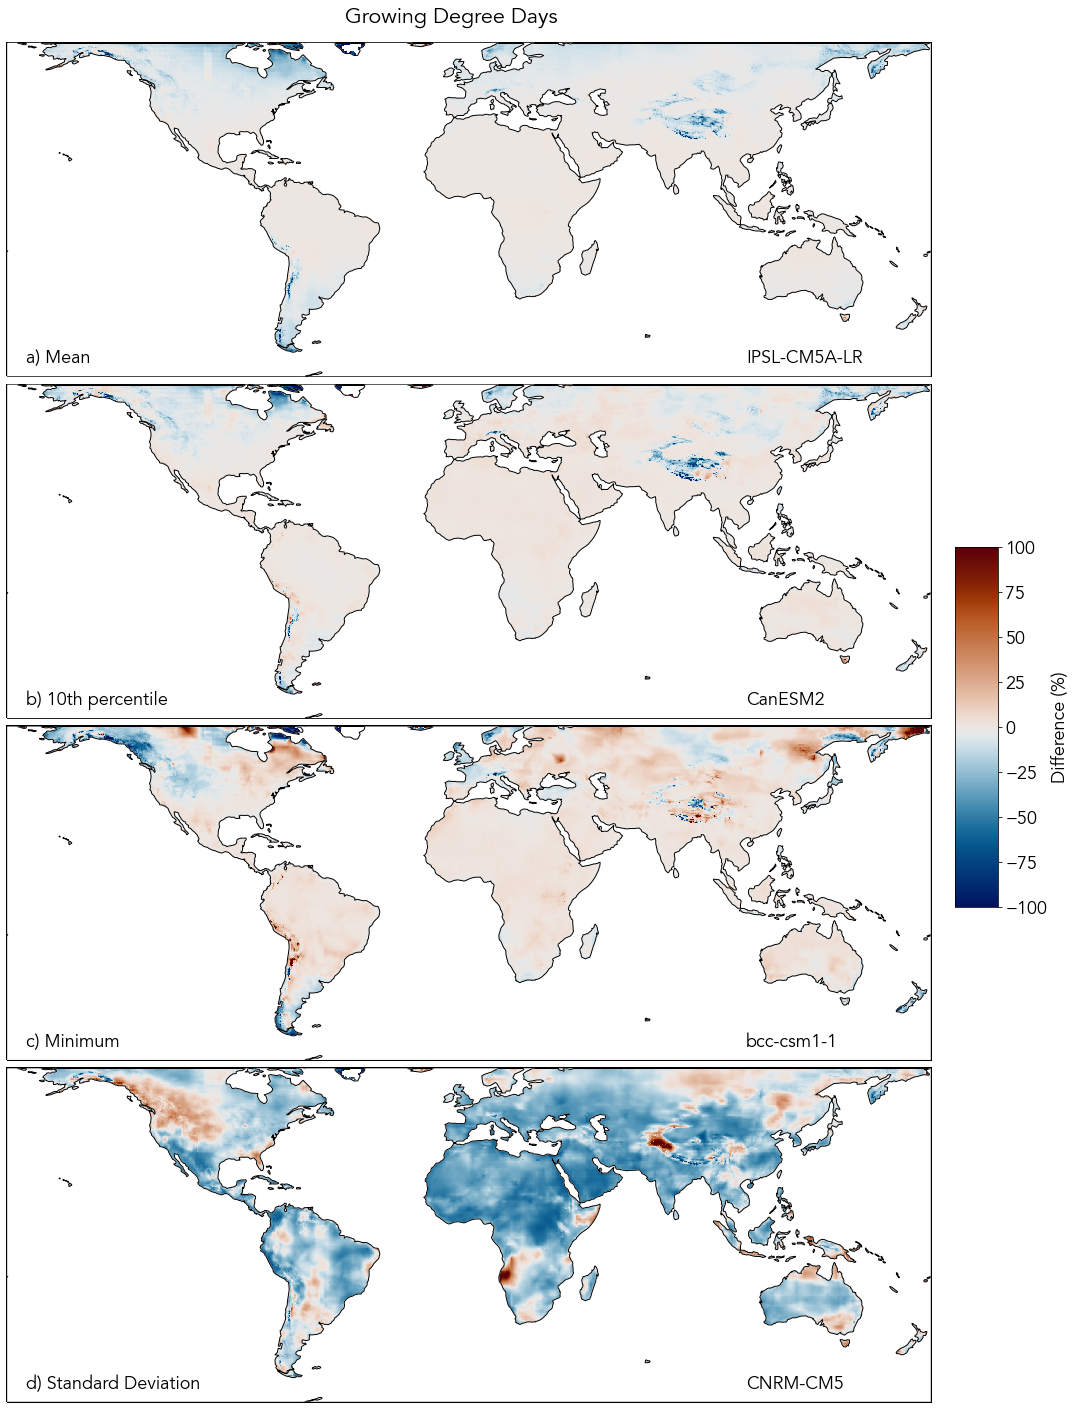

In [38]:
# Global
fig = plt.figure(figsize=(20,25))
gs = fig.add_gridspec(4,1, hspace=0.025)

cax = fig.add_axes([0.85, 0.4, 0.03, 0.2])

vmin = -100.
vmax = 100.
cmap = vik_map

# Mean
ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -65, 65], crs=ccrs.PlateCarree())

plotdata = (ds_mean - obs_mean) / np.abs(obs_mean) * 100
plotdata['GDD'].plot(ax=ax, transform=ccrs.PlateCarree(),  cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(cfeature.OCEAN, color='white', zorder=50)
ax.coastlines(resolution='110m', color='black', zorder=100)
ax.text(0.02, 0.04, 'a) Mean', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath, zorder=150)
ax.text(0.8, 0.04, mpm_mean, transform=ax.transAxes, size=18, font=fpath, zorder=150)
ax.spines['geo'].set_linewidth(2)
ax.spines['geo'].set_edgecolor('black')

# 90th percentile
ax = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -65, 65], crs=ccrs.PlateCarree())

plotdata = (ds_q10 - obs_q10) / np.abs(obs_q10) * 100
plotdata['GDD'].plot(ax=ax, transform = ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(cfeature.OCEAN, color='white', zorder=50)
ax.coastlines(resolution='110m', color='black', zorder=100)
ax.text(0.02, 0.04, 'b) 10th percentile', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath, zorder=150)
ax.text(0.8, 0.04, mpm_q10, transform=ax.transAxes, size=18, font=fpath, zorder=150)
ax.spines['geo'].set_linewidth(2)
ax.spines['geo'].set_edgecolor('black')

# Min
ax = fig.add_subplot(gs[2], projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -65, 65], crs=ccrs.PlateCarree())

plotdata = (ds_min - obs_min) / np.abs(obs_min) * 100
plotdata['GDD'].plot(ax=ax, transform = ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(cfeature.OCEAN, color='white', zorder=50)
ax.coastlines(resolution='110m', color='black', zorder=100)
ax.text(0.02, 0.04, 'c) Minimum', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath, zorder=150)
ax.text(0.8, 0.04, mpm_min, transform=ax.transAxes, size=18, font=fpath, zorder=150)
ax.spines['geo'].set_linewidth(2)
ax.spines['geo'].set_edgecolor('black')

# SD
ax = fig.add_subplot(gs[3], projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -65, 65], crs=ccrs.PlateCarree())

plotdata = (ds_sd - obs_sd) / np.abs(obs_sd) * 100
plotdata['GDD'].plot(ax=ax, transform = ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(cfeature.OCEAN, color='white', zorder=50)
ax.coastlines(resolution='110m', color='black', zorder=100)
ax.text(0.02, 0.04, 'd) Standard Deviation', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath, zorder=150)
ax.text(0.8, 0.04, mpm_sd, transform=ax.transAxes, size=18, font=fpath, zorder=150)
ax.spines['geo'].set_linewidth(2)
ax.spines['geo'].set_edgecolor('black')

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cb = fig.colorbar(sm, orientation = 'vertical', shrink=0.4, cax = cax)
cb.set_label(label = 'Difference (%)', font=fpath)
for tick in cb.ax.get_xticklabels():
    tick.set_font(fpath)
    
# Font
fig.suptitle('Growing Degree Days', font_properties={'fname':fpath}, y=0.9)

plt.savefig('./figs/SIfig_NEX_GDD_grid_global_map.png', dpi=600)
# plt.show()

## NEX Precip

In [45]:
# Get list of models
models = !ls /gpfs/group/kaf26/default/dcl5300/maize_yield_predictor_vars/precip/NEX/data/cuml*_historical_*
models = [model.replace('/gpfs/group/kaf26/default/dcl5300/maize_yield_predictor_vars/precip/NEX/data/cuml_precip_gs__historical_r1i1p1_','') for model in models]
models = [model.replace('.nc','') for model in models]

nex_path = '/gpfs/group/kaf26/default/dcl5300/maize_yield_predictor_vars/precip/NEX/data/cuml_precip_gs__historical_r1i1p1_'

In [46]:
# Read in all
ds = []
for model in models:
    tmp = xr.open_dataset(nex_path + model + '.nc')
    tmp = tmp.rename({'prcp' : model})
    ds.append(tmp)
    
ds = xr.merge(ds)

In [47]:
# US subset
ds_US = ds.where((ds.lon <= 360-65) & (ds.lon >= 360-125) & (ds.lat <= 50) & (ds.lat >= 25), drop=True)

In [48]:
# US subset
countries_110 = regionmask.defined_regions.natural_earth.countries_110
mask_3D = countries_110.mask_3D(ds_US)
us_mask = mask_3D.sel(region=4)
ds_US = ds.where(us_mask, drop=True)

In [49]:
# Precip models
mpm_mean = 'CanESM2'
mpm_q10 = 'GFDL-ESM2G'
mpm_sd = 'ACCESS1-0'
mpm_min = 'ACCESS1-0'

In [50]:
# Calculate summary stats
ds_US_mean = ds_US[mpm_mean].mean(dim=['time'])
ds_US_sd = ds_US[mpm_sd].std(dim=['time'])
ds_US_q10 = ds_US[mpm_q10].quantile(q=0.1, dim=['time'])
ds_US_min = ds_US[mpm_min].min(dim=['time'])

ds_mean = ds[mpm_mean].mean(dim=['time'])
ds_sd = ds[mpm_sd].std(dim=['time'])
ds_q10 = ds[mpm_q10].quantile(q=0.1, dim=['time'])
ds_min = ds[mpm_min].min(dim=['time'])

In [51]:
# Read in obs
obs = xr.open_dataset('/gpfs/group/kaf26/default/dcl5300/maize_yield_predictor_vars/precip/GMFD/data/cuml_precip_gs_GMFD.nc')

In [52]:
# Initial subset
obs_US = obs.where((obs.lon <= 360-65) & (obs.lon >= 360-125) & (obs.lat <= 50) & (obs.lat >= 25), drop=True)

In [53]:
# US subset
countries_110 = regionmask.defined_regions.natural_earth.countries_110
mask_3D = countries_110.mask_3D(ds)
us_mask = mask_3D.sel(region=4)
obs_US = obs.where(us_mask, drop=True)

In [54]:
# Calculate summary stats
obs_mean = obs.mean(dim=['time'])
obs_sd = obs.std(dim=['time'])
obs_q10 = obs.quantile(q=0.1, dim=['time'])
obs_min = obs.min(dim=['time'])

obs_US_mean = obs_US.mean(dim=['time'])
obs_US_sd = obs_US.std(dim=['time'])
obs_US_q10 = obs_US.quantile(q=0.1, dim=['time'])
obs_US_min = obs_US.min(dim=['time'])

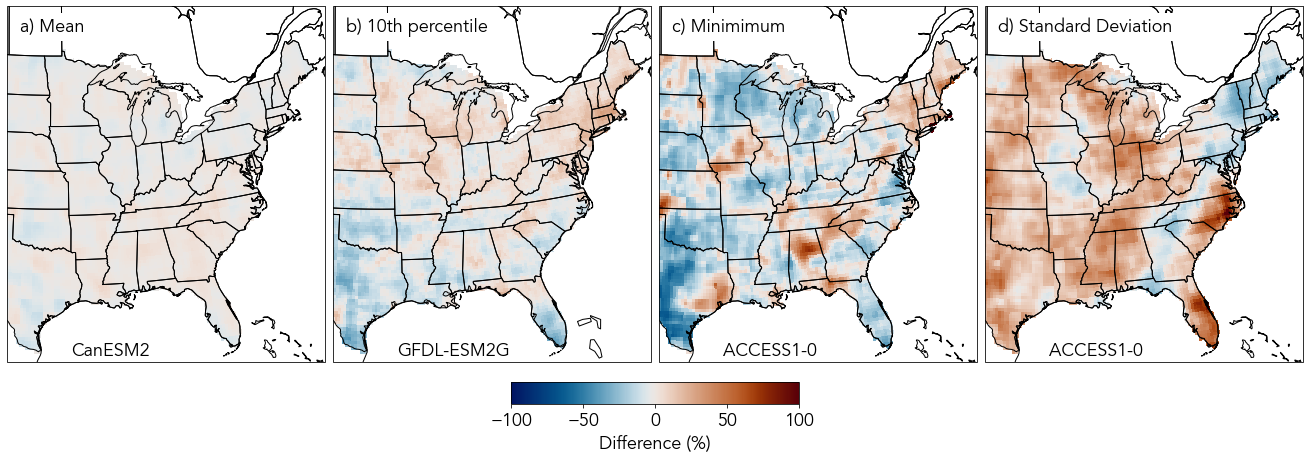

In [57]:
# US
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(1, 4, wspace = 0.025)

gs.update(top = 0.95, bottom = 0.1, left = 0.05, right = 0.95)
cax = fig.add_axes([0.4, 0.22, 0.2, 0.03])

vmin = -100.
vmax = 100.
cmap = vik_map

# Mean
ax = fig.add_subplot(gs[0], projection=ccrs.LambertConformal())
ax.set_extent([-100, -73, 25, 51], crs=ccrs.PlateCarree())

plotdata = (ds_US_mean - obs_US_mean) / np.abs(obs_US_mean) * 100
plotdata['prcp'].plot(ax=ax, transform = ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(states_provinces, edgecolor='black')
ax.coastlines(resolution='50m', color='black')
ax.text(0.04, 0.93, 'a) Mean', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath)
ax.text(0.2, 0.02, mpm_mean, transform=ax.transAxes, size=18, font=fpath)

# 10th percentile
ax = fig.add_subplot(gs[1], projection=ccrs.LambertConformal())
ax.set_extent([-100, -73, 25, 51], crs=ccrs.PlateCarree())

plotdata = (ds_US_q10 - obs_US_q10) / np.abs(obs_US_q10) * 100
plotdata['prcp'].plot(ax=ax, transform = ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(states_provinces, edgecolor='black')
ax.coastlines(resolution='110m', color='black')
ax.text(0.04, 0.93, 'b) 10th percentile', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath)
ax.text(0.2, 0.02, mpm_q10, transform=ax.transAxes, size=18, font=fpath)

# Min
ax = fig.add_subplot(gs[2], projection=ccrs.LambertConformal())
ax.set_extent([-100, -73, 25, 51], crs=ccrs.PlateCarree())

plotdata = (ds_US_min - obs_US_min) / np.abs(obs_US_min) * 100
plotdata['prcp'].plot(ax=ax, transform = ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(states_provinces, edgecolor='black')
ax.coastlines(resolution='50m', color='black')
ax.text(0.04, 0.93, 'c) Minimimum', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath)
ax.text(0.2, 0.02, mpm_min, transform=ax.transAxes, size=18, font=fpath)

# SD
ax = fig.add_subplot(gs[3], projection=ccrs.LambertConformal())
ax.set_extent([-100, -73, 25, 51], crs=ccrs.PlateCarree())

plotdata = (ds_US_sd - obs_US_sd) / np.abs(obs_US_sd) * 100
plotdata['prcp'].plot(ax=ax, transform = ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(states_provinces, edgecolor='black')
ax.coastlines(resolution='50m', color='black')
ax.text(0.04, 0.93, 'd) Standard Deviation', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath)
ax.text(0.2, 0.02, mpm_sd, transform=ax.transAxes, size=18, font=fpath)

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cb = fig.colorbar(sm, orientation = 'horizontal', shrink=0.4, cax = cax)
cb.set_label(label = 'Difference (%)', font=fpath)
for tick in cb.ax.get_xticklabels():
    tick.set_font(fpath)

plt.savefig('./figs/SIfig_NEX_prcp_grid_US_map.png', dpi=600)
# plt.show()

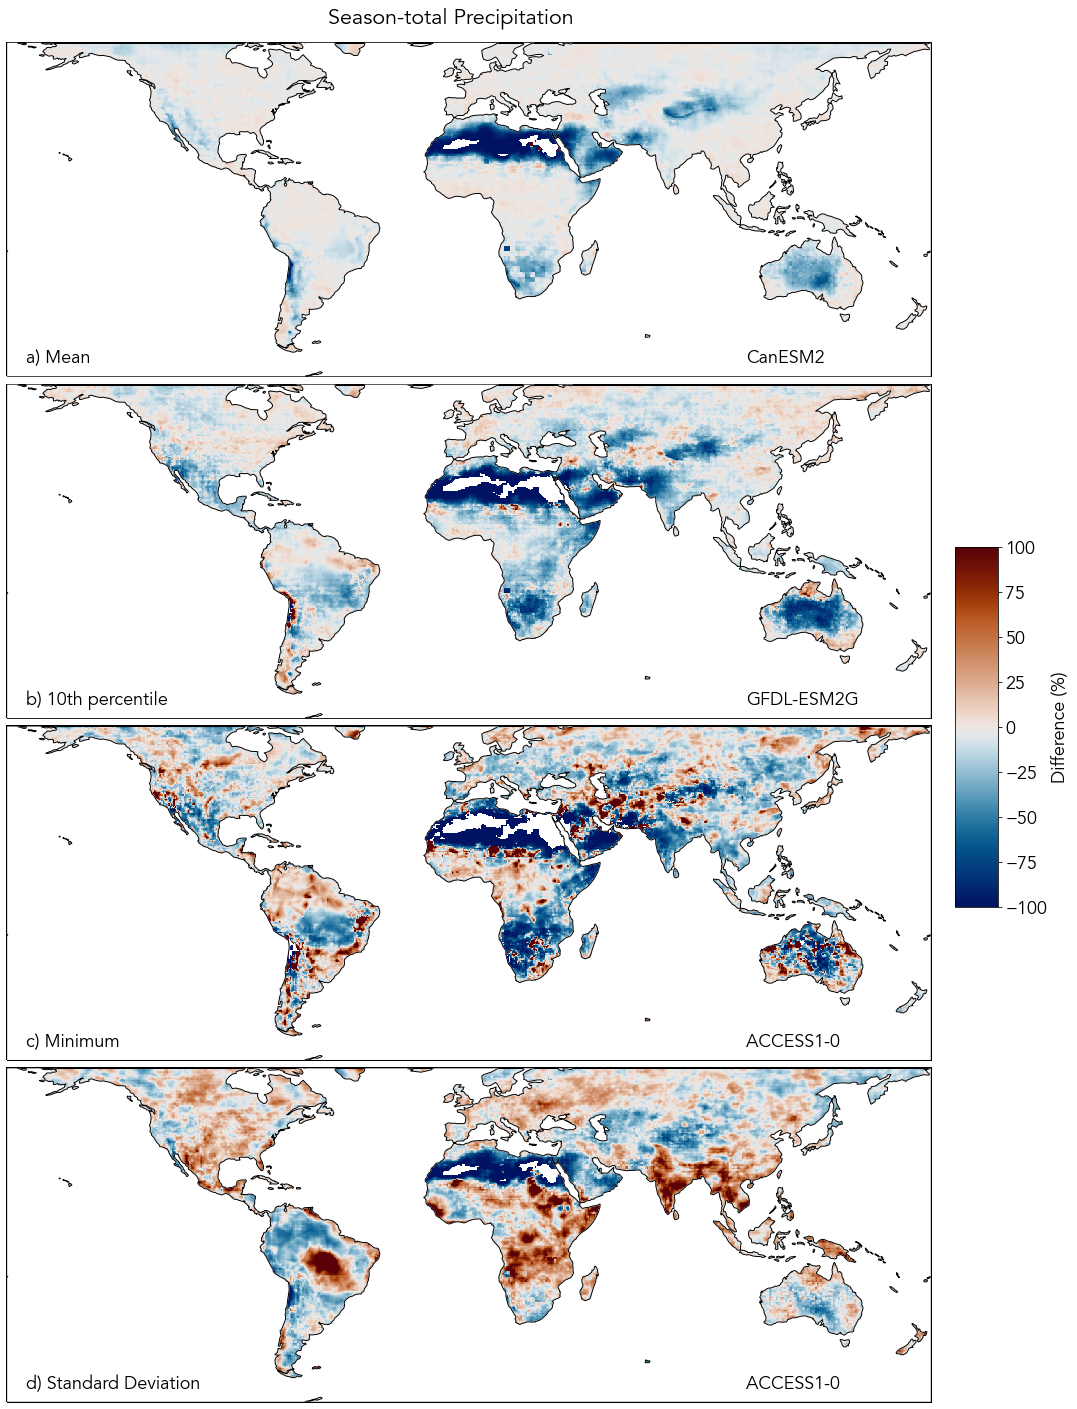

In [56]:
# Global
fig = plt.figure(figsize=(20,25))
gs = fig.add_gridspec(4,1, hspace=0.025)

cax = fig.add_axes([0.85, 0.4, 0.03, 0.2])

vmin = -100.
vmax = 100.
cmap = vik_map

# Mean
ax = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -65, 65], crs=ccrs.PlateCarree())

plotdata = (ds_mean - obs_mean) / np.abs(obs_mean) * 100
plotdata['prcp'].plot(ax=ax, transform=ccrs.PlateCarree(),  cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(cfeature.OCEAN, color='white', zorder=50)
ax.coastlines(resolution='110m', color='black', zorder=100)
ax.text(0.02, 0.04, 'a) Mean', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath, zorder=150)
ax.text(0.8, 0.04, mpm_mean, transform=ax.transAxes, size=18, font=fpath, zorder=150)
ax.spines['geo'].set_linewidth(2)
ax.spines['geo'].set_edgecolor('black')

# 90th percentile
ax = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -65, 65], crs=ccrs.PlateCarree())

plotdata = (ds_q10 - obs_q10) / np.abs(obs_q10) * 100
plotdata['prcp'].plot(ax=ax, transform = ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(cfeature.OCEAN, color='white', zorder=50)
ax.coastlines(resolution='110m', color='black', zorder=100)
ax.text(0.02, 0.04, 'b) 10th percentile', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath, zorder=150)
ax.text(0.8, 0.04, mpm_q10, transform=ax.transAxes, size=18, font=fpath, zorder=150)
ax.spines['geo'].set_linewidth(2)
ax.spines['geo'].set_edgecolor('black')

# Min
ax = fig.add_subplot(gs[2], projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -65, 65], crs=ccrs.PlateCarree())

plotdata = (ds_min - obs_min) / np.abs(obs_min) * 100
plotdata['prcp'].plot(ax=ax, transform = ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(cfeature.OCEAN, color='white', zorder=50)
ax.coastlines(resolution='110m', color='black', zorder=100)
ax.text(0.02, 0.04, 'c) Minimum', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath, zorder=150)
ax.text(0.8, 0.04, mpm_min, transform=ax.transAxes, size=18, font=fpath, zorder=150)
ax.spines['geo'].set_linewidth(2)
ax.spines['geo'].set_edgecolor('black')

# SD
ax = fig.add_subplot(gs[3], projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -65, 65], crs=ccrs.PlateCarree())

plotdata = (ds_sd - obs_sd) / np.abs(obs_sd) * 100
plotdata['prcp'].plot(ax=ax, transform = ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax, add_labels=False, add_colorbar=False)

ax.add_feature(cfeature.OCEAN, color='white', zorder=50)
ax.coastlines(resolution='110m', color='black', zorder=100)
ax.text(0.02, 0.04, 'd) Standard Deviation', transform=ax.transAxes, size=18, backgroundcolor='white', font=fpath, zorder=150)
ax.text(0.8, 0.04, mpm_sd, transform=ax.transAxes, size=18, font=fpath, zorder=150)
ax.spines['geo'].set_linewidth(2)
ax.spines['geo'].set_edgecolor('black')

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
cb = fig.colorbar(sm, orientation = 'vertical', shrink=0.4, cax = cax)
cb.set_label(label = 'Difference (%)', font=fpath)
for tick in cb.ax.get_xticklabels():
    tick.set_font(fpath)
    
# Font
fig.suptitle('Season-total Precipitation', font_properties={'fname':fpath}, y=0.9)

plt.savefig('./figs/SIfig_NEX_prcp_grid_global_map.png', dpi=600)
# plt.show()

# Figure 4

In [6]:
# Get list of models
models = !ls /gpfs/group/kaf26/default/dcl5300/maize_yield_predictor_vars/egdd/NEX/data/GDD_29C_gs__historical_r1i1p1_*
models = [model.replace('/gpfs/group/kaf26/default/dcl5300/maize_yield_predictor_vars/egdd/NEX/data/GDD_29C_gs__historical_r1i1p1_','') for model in models]
models = [model.replace('.nc','') for model in models]

path_min = '/gpfs/group/kaf26/default/public/NEX-GDDP/raw/tasmin_day_BCSD_historical_r1i1p1_'
path_max = '/gpfs/group/kaf26/default/public/NEX-GDDP/raw/tasmax_day_BCSD_historical_r1i1p1_'

In [7]:
# Read in all
ds_max = []
for model in models:
    tmp = xr.open_dataset(path_max + model + '_1980.nc', use_cftime=True)
    tmp = tmp.rename({'tasmax' : model})
    tmp = tmp.sel(time=tmp.time.dt.month.isin([3, 4, 5, 6, 7, 8]))
    tmp = tmp.where((tmp.lon <= 360-65) & (tmp.lon >= 360-125) & (tmp.lat <= 50) & (tmp.lat >= 25), drop=True)
    ds_max.append(tmp)
    
ds_min = []
for model in models:
    tmp = xr.open_dataset(path_min + model + '_1980.nc', use_cftime=True)
    tmp = tmp.rename({'tasmin' : model})
    tmp = tmp.sel(time=tmp.time.dt.month.isin([3, 4, 5, 6, 7, 8]))
    tmp = tmp.where((tmp.lon <= 360-65) & (tmp.lon >= 360-125) & (tmp.lat <= 50) & (tmp.lat >= 25), drop=True)
    ds_min.append(tmp)
    
# # Read in all
# ds = []
# for model in models:a
#     tmp = xr.open_mfdataset(path + model + '*.nc', chunks='auto', use_cftime=True)
#     tmp = tmp.rename({'tasmax' : model})
#     tmp = tmp.sel(time=tmp.time.dt.month.isin([3, 4, 5, 6, 7, 8]))
#     tmp = tmp.where((tmp.lon <= 360-65) & (tmp.lon >= 360-125) & (tmp.lat <= 50) & (tmp.lat >= 25), drop=True)
#     ds.append(tmp.persist())

In [8]:
# There are some (not many) models with different calendars. Most are DatetimeNoLeap so convert to this.
def to_365day(da):
    '''Takes a DataArray. Change the calendar to NoLeap'''
    val = da.copy()
    time1 = da.time.copy()
    for itime in range(val.sizes['time']):
        bb = val.time.values[itime].timetuple()
        time1.values[itime] = cftime.DatetimeNoLeap(bb[0],bb[1],bb[2])

    # We rename the time dimension and coordinate to timeNoLeap to make it clear it isn't 
    # the original time coordinate.
    val = val.rename({'time':'timeNoLeap'})
    time1 = time1.rename({'time':'timeNoLeap'})
    val = val.assign_coords({'timeNoLeap':time1})
    return val

In [9]:
# Convert and merge
ds_min = [to_365day(model) for model in ds_min]
ds_max = [to_365day(model) for model in ds_max]
ds_min = xr.merge(ds_min)
ds_max = xr.merge(ds_max)

In [10]:
# US subset
countries_110 = regionmask.defined_regions.natural_earth.countries_110
mask_3D = countries_110.mask_3D(ds_min)
us_mask = mask_3D.sel(region=4)
ds_min = ds_min.where(us_mask, drop=True)
ds_max = ds_max.where(us_mask, drop=True)

In [11]:
# Read in obs
# obs = xr.open_mfdataset('/gpfs/group/kaf26/default/rls66/GMFD_25/tmax_daily_*.nc', chunks='auto')
obs_max = xr.open_dataset('/gpfs/group/kaf26/default/rls66/GMFD_25/tmax_daily_1980-1980.nc')
obs_min = xr.open_dataset('/gpfs/group/kaf26/default/rls66/GMFD_25/tmin_daily_1980-1980.nc')

In [12]:
# Initial subset
obs_max = obs_max.where((obs_max.lon <= 360-65) & (obs_max.lon >= 360-125) & (obs_max.lat <= 50) & (obs_max.lat >= 25), drop=True)
obs_max = obs_max.sel(time=obs_max.time.dt.month.isin([3, 4, 5, 6, 7, 8]))
obs_max = obs_max.where(obs_max.time.dt.year <= 2005, drop=True)

obs_min = obs_min.where((obs_min.lon <= 360-65) & (obs_min.lon >= 360-125) & (obs_min.lat <= 50) & (obs_min.lat >= 25), drop=True)
obs_min = obs_min.sel(time=obs_min.time.dt.month.isin([3, 4, 5, 6, 7, 8]))
obs_min = obs_min.where(obs_min.time.dt.year <= 2005, drop=True)

In [13]:
# US subset
countries_110 = regionmask.defined_regions.natural_earth.countries_110
mask_3D = countries_110.mask_3D(ds_min)
us_mask = mask_3D.sel(region=4)
obs_min = obs_min.where(us_mask, drop=True)
obs_max = obs_max.where(us_mask, drop=True)

In [29]:
ds_min[model].isel(lat=lat_id, lon=lon_id).lat.values

array(41.375, dtype=float32)

In [36]:
lat_id = 61
lon_id = 143
1*ds_min[model].isel(lat=lat_id, lon=lon_id).lat.values, 360-ds_min[model].isel(lat=lat_id, lon=lon_id).lon.values

(40.375, 88.875)

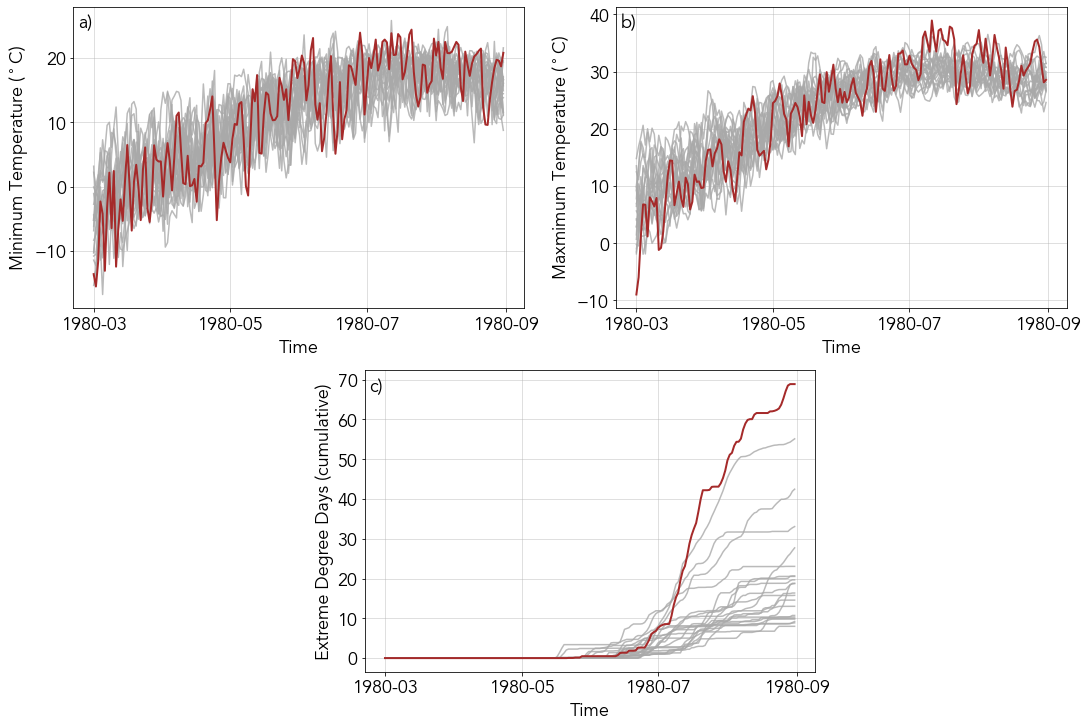

In [37]:
fig = plt.figure(constrained_layout=True, figsize=(15,10))
gs = GridSpec(2, 4, figure=fig, wspace=0.05)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:])
ax3 = fig.add_subplot(gs[1, 1:-1])

model_lw = 1.5
obs_lw = 2
# model_c = '#9ecae1'
model_c = 'darkgray'
obs_c = 'brown'
pooled_c = 'black'
model_alpha = 0.9

# Tmin
ax=ax1
for model in models:
    (ds_min[model].isel(lat=lat_id, lon=lon_id) - 273.0).plot(ax=ax, color='darkgrey', lw=model_lw, alpha=0.8)

ax.plot(ds_min[model].isel(lat=lat_id, lon=lon_id).timeNoLeap, obs_min['tmin'].isel(lat=lat_id, lon=lon_id).values - 273.0, color='brown', lw=obs_lw)
ax.set_ylabel('Minimum Temperature ($^\circ$C)', font=fpath)
ax.set_xlabel('Time')
ax.set_title('')
ax.grid(alpha=0.5)
ax.text(0.01, 0.93, 'a)', transform=ax.transAxes)

# Tmax
ax=ax2
for model in models:
    (ds_max[model].isel(lat=lat_id, lon=lon_id) - 273.0).plot(ax=ax, color='darkgrey', lw=model_lw, alpha=0.8)

ax.plot(ds_max[model].isel(lat=lat_id, lon=lon_id).timeNoLeap, obs_max['tmax'].isel(lat=lat_id, lon=lon_id).values - 273.0, color='brown', lw=obs_lw)
ax.set_ylabel('Maxmimum Temperature ($^\circ$C)', font=fpath)
ax.set_xlabel('Time')
ax.set_title('')
ax.grid(alpha=0.5)
ax.text(0.01, 0.93, 'b)', transform=ax.transAxes)

# EDD cumulative
ax=ax3
for model in models:
    np.cumsum(above_threshold_each(ds_min[model].isel(lat=lat_id, lon=lon_id),
                                   ds_max[model].isel(lat=lat_id, lon=lon_id), 29.0+273.0)).plot(ax=ax, color='darkgrey', lw=model_lw, alpha=0.8)

ax.plot(ds_max[model].isel(lat=lat_id, lon=lon_id).timeNoLeap, np.cumsum(above_threshold_each(obs_min['tmin'].isel(lat=lat_id, lon=lon_id).values,
                                                                  obs_max['tmax'].isel(lat=lat_id, lon=lon_id).values, 29.0+273.0)),
                                                                  color='brown', lw=obs_lw)
ax.set_ylabel('Extreme Degree Days (cumulative)', font=fpath)
ax.set_xlabel('Time')
ax.set_title('')
ax.grid(alpha=0.5)
ax.text(0.01, 0.93, 'c)', transform=ax.transAxes)

plt.savefig('./figs/Figure4.pdf')
# plt.show()

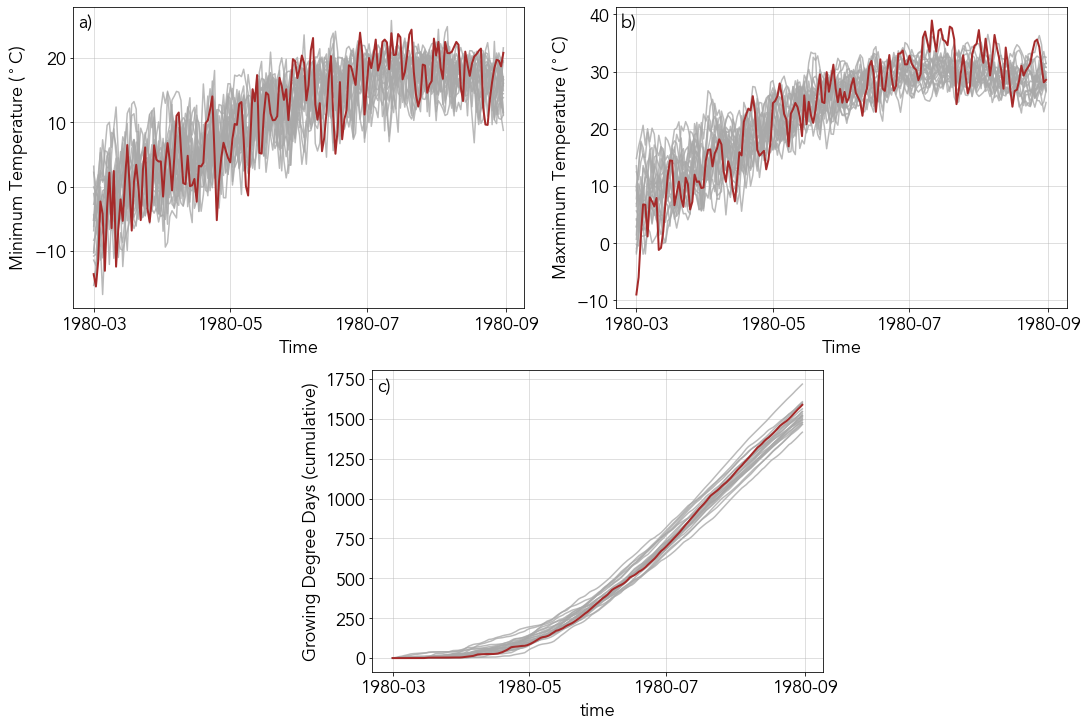

In [39]:
# SI fig for GDD
fig = plt.figure(constrained_layout=True, figsize=(15,10))
gs = GridSpec(2, 4, figure=fig, wspace=0.05)
ax1 = fig.add_subplot(gs[1, 1:-1])
ax2 = fig.add_subplot(gs[0, :2])
ax3 = fig.add_subplot(gs[0, 2:])

model_lw = 1.5
obs_lw = 2
# model_c = '#9ecae1'
model_c = 'darkgray'
obs_c = 'brown'
pooled_c = 'black'
model_alpha = 0.9

# min
ax=ax2
for model in models:
    (ds_min[model].isel(lat=lat_id, lon=lon_id) - 273.0).plot(ax=ax, color='darkgrey', lw=model_lw, alpha=0.8)

ax.plot(ds_min[model].isel(lat=lat_id, lon=lon_id).timeNoLeap, obs_min['tmin'].isel(lat=lat_id, lon=lon_id).values - 273.0, color='brown', lw=obs_lw)
ax.set_ylabel('Minimum Temperature ($^\circ$C)', font=fpath)
ax.set_xlabel('Time')
ax.set_title('')
ax.grid(alpha=0.5)
ax.text(0.01, 0.93, 'a)', transform=ax.transAxes)

# max
ax=ax3
for model in models:
    (ds_max[model].isel(lat=lat_id, lon=lon_id) - 273.0).plot(ax=ax, color='darkgrey', lw=model_lw, alpha=0.8)

ax.plot(ds_max[model].isel(lat=lat_id, lon=lon_id).timeNoLeap, obs_max['tmax'].isel(lat=lat_id, lon=lon_id).values - 273.0, color='brown', lw=obs_lw)
ax.set_ylabel('Maxmimum Temperature ($^\circ$C)', font=fpath)
ax.set_xlabel('Time')
ax.set_title('')
ax.grid(alpha=0.5)
ax.text(0.01, 0.93, 'b)', transform=ax.transAxes)

# gdd
ax=ax1
for model in models:
    np.cumsum(above_threshold_each(ds_min[model].isel(lat=lat_id, lon=lon_id),
                         ds_max[model].isel(lat=lat_id, lon=lon_id), 10.0+273.0) - 
              above_threshold_each(ds_min[model].isel(lat=lat_id, lon=lon_id),
                         ds_max[model].isel(lat=lat_id, lon=lon_id), 29.0+273.0)).plot(ax=ax, color='darkgrey', lw=model_lw, alpha=0.8)

ax.plot(ds_max[model].isel(lat=lat_id, lon=lon_id).timeNoLeap, np.cumsum(above_threshold_each(obs_min['tmin'].isel(lat=lat_id, lon=lon_id).values,
                                                                  obs_max['tmax'].isel(lat=lat_id, lon=lon_id).values, 10.0+273.0) - 
                                                                         above_threshold_each(obs_min['tmin'].isel(lat=lat_id, lon=lon_id).values,
                                                                  obs_max['tmax'].isel(lat=lat_id, lon=lon_id).values, 29.0+273.0)),
                                                                  color='brown', lw=obs_lw)
ax.set_ylabel('Growing Degree Days (cumulative)', font=fpath)
ax.set_title('')
ax.grid(alpha=0.5)
ax.text(0.01, 0.93, 'c)', transform=ax.transAxes)

plt.savefig('./figs/SIfig_yr1980_GDD_timeseries.pdf')
# plt.show()

## CMIP equivalent

In [6]:
# for obs
lat_id = 61
lon_id = 143

In [7]:
# Read in obs
# obs = xr.open_mfdataset('/gpfs/group/kaf26/default/rls66/GMFD_25/tmax_daily_*.nc', chunks='auto')
obs_max = xr.open_dataset('/gpfs/group/kaf26/default/rls66/GMFD_25/tmax_daily_1980-1980.nc')
obs_min = xr.open_dataset('/gpfs/group/kaf26/default/rls66/GMFD_25/tmin_daily_1980-1980.nc')

In [8]:
# Initial subset
obs_max = obs_max.where((obs_max.lon <= 360-65) & (obs_max.lon >= 360-125) & (obs_max.lat <= 50) & (obs_max.lat >= 25), drop=True)
obs_max = obs_max.sel(time=obs_max.time.dt.month.isin([3, 4, 5, 6, 7, 8]))
obs_max = obs_max.where(obs_max.time.dt.year <= 2005, drop=True)

obs_min = obs_min.where((obs_min.lon <= 360-65) & (obs_min.lon >= 360-125) & (obs_min.lat <= 50) & (obs_min.lat >= 25), drop=True)
obs_min = obs_min.sel(time=obs_min.time.dt.month.isin([3, 4, 5, 6, 7, 8]))
obs_min = obs_min.where(obs_min.time.dt.year <= 2005, drop=True)

In [10]:
# US subset
countries_110 = regionmask.defined_regions.natural_earth.countries_110
mask_3D = countries_110.mask_3D(obs_min)
us_mask = mask_3D.sel(region=4)
obs_min = obs_min.where(us_mask, drop=True)
obs_max = obs_max.where(us_mask, drop=True)

In [11]:
# Get list of NEX models
models = !ls /gpfs/group/kaf26/default/dcl5300/maize_yield_predictor_vars/egdd/NEX/data/GDD_29C_gs__historical_r1i1p1_*
models = [model.replace('/gpfs/group/kaf26/default/dcl5300/maize_yield_predictor_vars/egdd/NEX/data/GDD_29C_gs__historical_r1i1p1_','') for model in models]
models = [model.replace('.nc','') for model in models]

path_min = '/gpfs/group/kaf26/default/public/NEX-GDDP/raw/tasmin_day_BCSD_historical_r1i1p1_'
path_max = '/gpfs/group/kaf26/default/public/NEX-GDDP/raw/tasmax_day_BCSD_historical_r1i1p1_'

In [12]:
# Get paths
min_model_paths = []
for model in models:
    model_path = '/gpfs/group/kaf26/default/rls66/cmip5_daily_temp_hist+rcp85/tasmin.day.' + model + '*'
    test = !ls $model_path
    if test[0][0] != 'l':
        min_model_paths.append(test[0])
    else:
        model_path = '/gpfs/group/kaf26/default/rls66/cmip5_missing/tasmin_day_' + model + '*'
        test = !ls $model_path
        min_model_paths.append(test[0])
        
max_model_paths = []
for model in models:
    model_path = '/gpfs/group/kaf26/default/rls66/cmip5_daily_temp_hist+rcp85/tasmax.day.' + model + '*'
    test = !ls $model_path
    if test[0][0] != 'l':
        max_model_paths.append(test[0])
    else:
        model_path = '/gpfs/group/kaf26/default/rls66/cmip5_missing/tasmax_day_' + model + '*'
        test = !ls $model_path
        max_model_paths.append(test[0])

In [13]:
%%time
# Read in all
ds_min = []
for model in min_model_paths:
    print(model)
    tmp = xr.open_dataset(model)
    tmp = tmp.where((tmp['time'] < 19810101), drop=True)
    tmp = tmp.where((tmp['time'] >= 19800101), drop=True)
    tmp['time'] = xr.DataArray.from_series(pd.to_datetime(tmp['time'].to_dataframe()['time'], format='%Y%m%d'))
    tmp = tmp.sel(time=tmp.time.dt.month.isin([3, 4, 5, 6, 7, 8]))
    tmp = tmp.sel(lat=40.375, lon=360-88.875, method='nearest')
    ds_min.append(tmp)
    
ds_max = []
for model in max_model_paths:
    print(model)
    tmp = xr.open_dataset(model)
    tmp = tmp.where((tmp['time'] < 19810101), drop=True)
    tmp = tmp.where((tmp['time'] >= 19800101), drop=True)
    tmp['time'] = xr.DataArray.from_series(pd.to_datetime(tmp['time'].to_dataframe()['time'], format='%Y%m%d'))
    tmp = tmp.sel(time=tmp.time.dt.month.isin([3, 4, 5, 6, 7, 8]))
    tmp = tmp.sel(lat=40.375, lon=360-88.875, method='nearest')
    ds_max.append(tmp)

/gpfs/group/kaf26/default/rls66/cmip5_daily_temp_hist+rcp85/tasmin.day.ACCESS1-0.historical+rcp85.r1i1p1.18500101-21001231.nc
/gpfs/group/kaf26/default/rls66/cmip5_daily_temp_hist+rcp85/tasmin.day.BNU-ESM.historical+rcp85.r1i1p1.19500101-21001231.nc
/gpfs/group/kaf26/default/rls66/cmip5_missing/tasmin_day_CCSM4_historical+rcp85_r1i1p1_18500101-23001231.nc
/gpfs/group/kaf26/default/rls66/cmip5_daily_temp_hist+rcp85/tasmin.day.CESM1-BGC.historical+rcp85.r1i1p1.18500101-21001231.nc
/gpfs/group/kaf26/default/rls66/cmip5_daily_temp_hist+rcp85/tasmin.day.CNRM-CM5.historical+rcp85.r1i1p1.18500101-21001231.nc
/gpfs/group/kaf26/default/rls66/cmip5_missing/tasmin_day_CSIRO-Mk3-6-0_historical+rcp85_r1i1p1_18500101-23001231.nc
/gpfs/group/kaf26/default/rls66/cmip5_daily_temp_hist+rcp85/tasmin.day.CanESM2.historical+rcp85.r1i1p1.18500101-21001231.nc
/gpfs/group/kaf26/default/rls66/cmip5_daily_temp_hist+rcp85/tasmin.day.GFDL-CM3.historical+rcp85.r1i1p1.18600101-21001231.nc
/gpfs/group/kaf26/default/

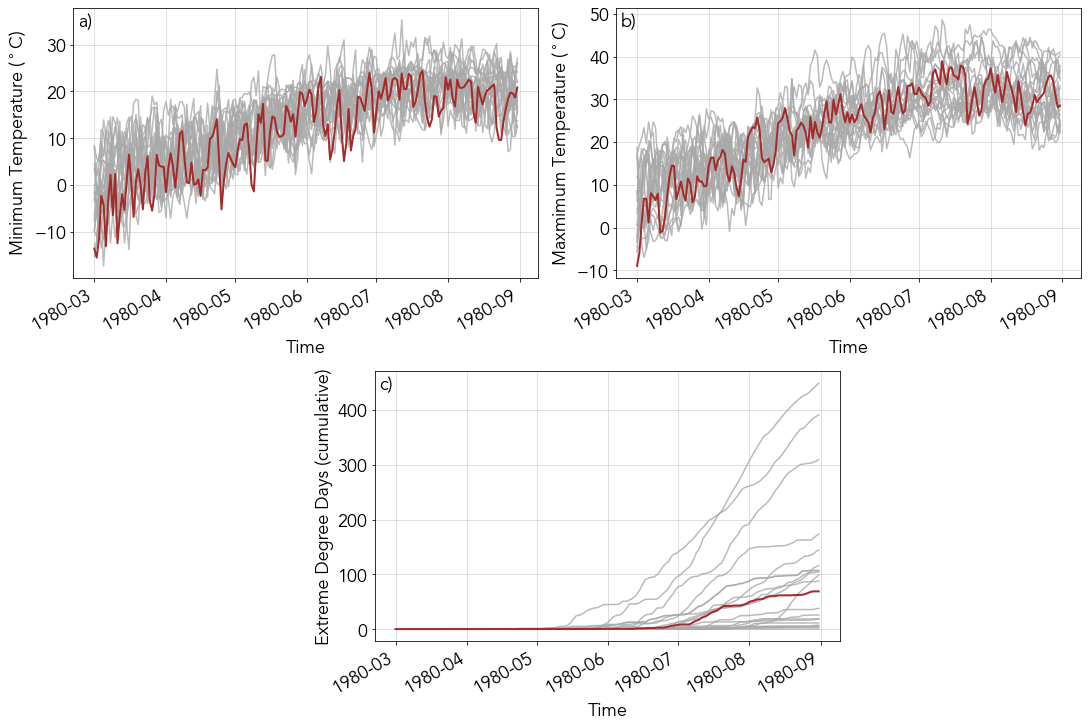

In [18]:
fig = plt.figure(constrained_layout=True, figsize=(15,10))
gs = GridSpec(2, 4, figure=fig, wspace=0.05)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:])
ax3 = fig.add_subplot(gs[1, 1:-1])

model_lw = 1.5
obs_lw = 2
# model_c = '#9ecae1'
model_c = 'darkgray'
obs_c = 'brown'
pooled_c = 'black'
model_alpha = 0.9

# Tmin
ax=ax1
for model in ds_min:
    (model['tasmin'] - 273.0).plot(ax=ax, color='darkgrey', lw=model_lw, alpha=0.8)

ax.plot(model.time, obs_min['tmin'].isel(lat=lat_id, lon=lon_id).values - 273.0, color='brown', lw=obs_lw)
ax.set_ylabel('Minimum Temperature ($^\circ$C)', font=fpath)
ax.set_xlabel('Time')
ax.set_title('')
ax.grid(alpha=0.5)
ax.text(0.01, 0.93, 'a)', transform=ax.transAxes)

# Tmax
ax=ax2
for model in ds_max:
    (model['tasmax'] - 273.0).plot(ax=ax, color='darkgrey', lw=model_lw, alpha=0.8)

ax.plot(ds_min[0].time, obs_max['tmax'].isel(lat=lat_id, lon=lon_id).values - 273.0, color='brown', lw=obs_lw)
ax.set_ylabel('Maxmimum Temperature ($^\circ$C)', font=fpath)
ax.set_xlabel('Time')
ax.set_title('')
ax.grid(alpha=0.5)
ax.text(0.01, 0.93, 'b)', transform=ax.transAxes)

# EDD cumulative
ax=ax3
for i in range(len(models)):
    np.cumsum(above_threshold_each(ds_min[i]['tasmin'],
                                   ds_max[i]['tasmax'], 29.0+273.0)).plot(ax=ax, color='darkgrey', lw=model_lw, alpha=0.8)

ax.plot(ds_min[0].time, np.cumsum(above_threshold_each(obs_min['tmin'].isel(lat=lat_id, lon=lon_id).values,
                                                                  obs_max['tmax'].isel(lat=lat_id, lon=lon_id).values, 29.0+273.0)),
                                                                  color='brown', lw=obs_lw)
ax.set_ylabel('Extreme Degree Days (cumulative)', font=fpath)
ax.set_xlabel('Time')
ax.set_title('')
ax.grid(alpha=0.5)
ax.text(0.01, 0.93, 'c)', transform=ax.transAxes)

plt.savefig('./figs/SIfig_CMIP_yr1980_timeseries.pdf')
# plt.show()

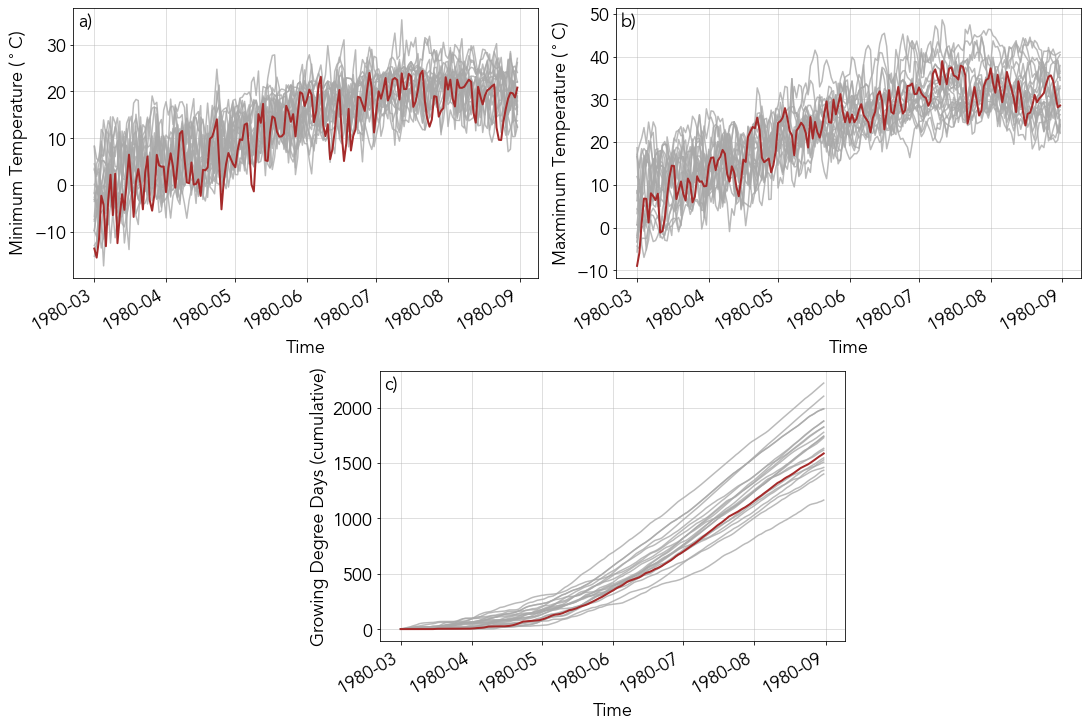

In [21]:
fig = plt.figure(constrained_layout=True, figsize=(15,10))
gs = GridSpec(2, 4, figure=fig, wspace=0.05)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:])
ax3 = fig.add_subplot(gs[1, 1:-1])

model_lw = 1.5
obs_lw = 2
# model_c = '#9ecae1'
model_c = 'darkgray'
obs_c = 'brown'
pooled_c = 'black'
model_alpha = 0.9

# Tmin
ax=ax1
for model in ds_min:
    (model['tasmin'] - 273.0).plot(ax=ax, color='darkgrey', lw=model_lw, alpha=0.8)

ax.plot(model.time, obs_min['tmin'].isel(lat=lat_id, lon=lon_id).values - 273.0, color='brown', lw=obs_lw)
ax.set_ylabel('Minimum Temperature ($^\circ$C)', font=fpath)
ax.set_xlabel('Time')
ax.set_title('')
ax.grid(alpha=0.5)
ax.text(0.01, 0.93, 'a)', transform=ax.transAxes)

# Tmax
ax=ax2
for model in ds_max:
    (model['tasmax'] - 273.0).plot(ax=ax, color='darkgrey', lw=model_lw, alpha=0.8)

ax.plot(ds_min[0].time, obs_max['tmax'].isel(lat=lat_id, lon=lon_id).values - 273.0, color='brown', lw=obs_lw)
ax.set_ylabel('Maxmimum Temperature ($^\circ$C)', font=fpath)
ax.set_xlabel('Time')
ax.set_title('')
ax.grid(alpha=0.5)
ax.text(0.01, 0.93, 'b)', transform=ax.transAxes)

# GDD cumulative
ax=ax3
for i in range(len(models)):
    np.cumsum(above_threshold_each(ds_min[i]['tasmin'],ds_max[i]['tasmax'], 10.0+273.0) - 
             above_threshold_each(ds_min[i]['tasmin'],ds_max[i]['tasmax'], 29.0+273.0)).plot(ax=ax, color='darkgrey', lw=model_lw, alpha=0.8)

ax.plot(ds_min[0].time, np.cumsum(above_threshold_each(obs_min['tmin'].isel(lat=lat_id, lon=lon_id).values, obs_max['tmax'].isel(lat=lat_id, lon=lon_id).values, 10.0+273.0) - 
                                 above_threshold_each(obs_min['tmin'].isel(lat=lat_id, lon=lon_id).values, obs_max['tmax'].isel(lat=lat_id, lon=lon_id).values, 29.0+273.0)),
        color='brown', lw=obs_lw)
ax.set_ylabel('Growing Degree Days (cumulative)', font=fpath)
ax.set_xlabel('Time')
ax.set_title('')
ax.grid(alpha=0.5)
ax.text(0.01, 0.93, 'c)', transform=ax.transAxes)

plt.savefig('./figs/SIfig_CMIP_yr1980_GDD_timeseries.pdf')
# plt.show()